__классификатор изображений на основе ResNet__

Евгений Борисов <esborisov@sevsu.ru>

---

Deep Residual Learning for Image Recognition  
Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun   
Microsoft Research   
10 Dec 2015  

https://arxiv.org/pdf/1512.03385.pdf

---

In [1]:
import numpy as np
from os import listdir
from os.path import join as pjoin
from PIL import Image
from matplotlib import pyplot as plt

## модель

In [2]:
import tensorflow as tf
from tabulate import tabulate
from tensorflow.test import is_built_with_cuda
from tensorflow.python.client.device_lib import list_local_devices

def tf_info(tablefmt='html'):
    res = [
        ['tensorflow','%s'%(tf.__version__)],
        ['keras','%s'%(tf.keras.__version__)]
    ]

    if is_built_with_cuda():
        res.extend( [ 
              [ s.strip().split(': ') for s in d.physical_device_desc.split(',')  ]
               for d in list_local_devices() 
              if d.device_type == 'GPU' # and d.name==tf.test.gpu_device_name()
            ][0] )
            
    else:
        res.append(['','no CUDA support'])

    return tabulate( res, tablefmt=tablefmt )

tf_info()

'<table>\n<tbody>\n<tr><td>tensorflow        </td><td>2.4.1                      </td></tr>\n<tr><td>keras             </td><td>2.4.0                      </td></tr>\n<tr><td>device            </td><td>0                          </td></tr>\n<tr><td>name              </td><td>NVIDIA GeForce GTX 1060 6GB</td></tr>\n<tr><td>pci bus id        </td><td>0000:01:00.0               </td></tr>\n<tr><td>compute capability</td><td>6.1                        </td></tr>\n</tbody>\n</table>'

## загружаем модель

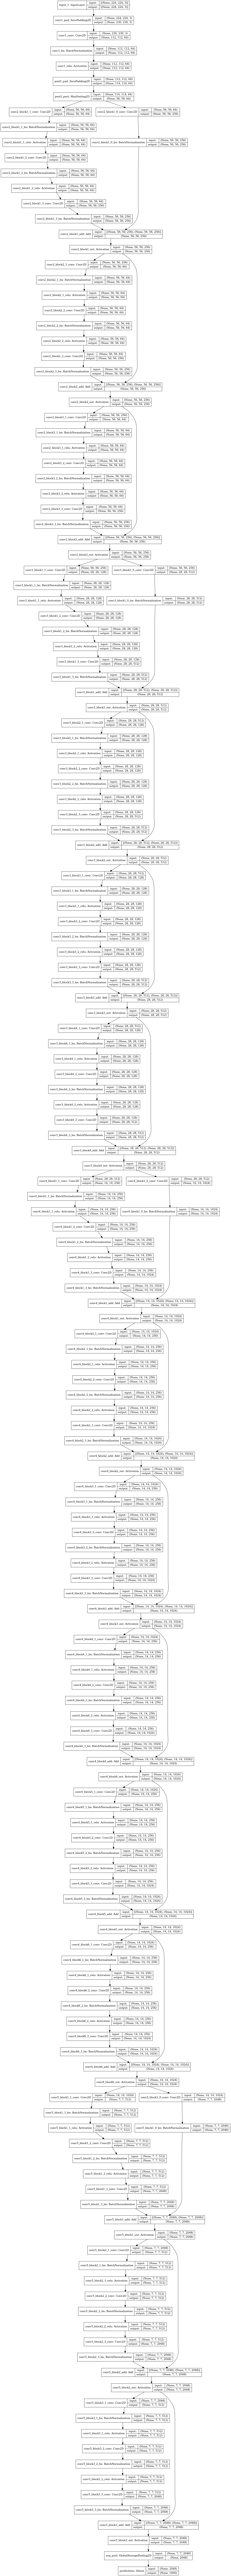

In [3]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import plot_model

# model = ResNet50(weights='data/imagenet/resnet50_weights_tf_dim_ordering_tf_kernels.h5')
model = ResNet50()
plot_model(model,to_file='resnet50.png', show_layer_names=True, show_shapes=True )

## тестируем

In [4]:
# !wget -P ../data/imagenet -c https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt

In [5]:
# http://www.image-net.org

fname_labels = '../data/imagenet/imagenet1000_clsidx_to_labels.txt'
with open(fname_labels, 'rt') as f:   imagenet_labels = eval(f.read())

image_folder ='../data/imagenet/photos/'
files = listdir(image_folder)

# def normalize(x):
#     x_mx,x_mn = x.max(axis=(1,2,3),keepdims=1), x.min(axis=(1,2,3),keepdims=1) 
#     return ((x-x_mn)/(x_mx-x_mn)).astype(np.float32)
#     # return np.transpose( ((x-x_mn)/(x_mx-x_mn)), axes=(0,3,1,2) ) 

def image2arr(im):
    return np.array(im.resize([224,224,]).convert('RGB')).astype(np.float32)[np.newaxis,:]

x = np.vstack([image2arr(Image.open(pjoin(image_folder,f))) for f in files])
x.shape

(10, 224, 224, 3)

In [6]:
def draw_images(
        x, # numpy тензор с картинками
        y=[], # метки классов
        class_names=None, # имена классов
        columns=3, # количество колонок в таблице с картинками  
        fig_width=14, # ширина таблицы с картинками
        num_ex=0, # рисуем только первые num_ex
        max_title_len=25 # максимальная длинна заголовка картинки
    ):
    # рисуем данные
    n_img = min(x.shape[0],num_ex) if num_ex>0 else x.shape[0]  # количество картинок для отображения
    col = columns # количество колонок
    w = fig_width # ширина таблицы с картинками
    h = (n_img//col)*(w//col) # высота таблицы с картинками

    fig = plt.figure(figsize=(w,h))
    for n in range(n_img):
        img = x[n,:] # извлекаем одну картинку
        plt.subplot(n_img//col+1,col,n+1) # создаём ячейку таблицы
        plt.axis(False) # оси координат не рисуем
        if len(y)==x.shape[0]:
            t = class_names[y[n]] # имя класса картинки
            t = t if len(t)<(max_title_len+1) else t[:max_title_len]+'...'
            plt.title(t) # заголовок картинки
        plt.imshow(img) # рисуем картинку
    fig.tight_layout() # выравниваем элементы таблицы


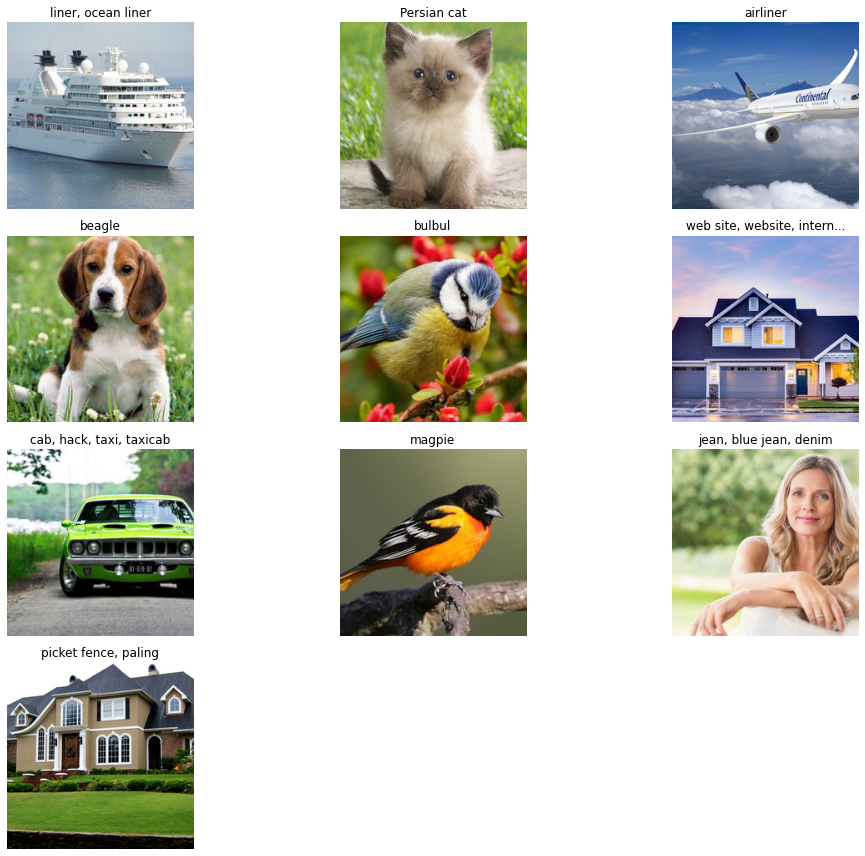

In [7]:
o = model.predict(x)
y = np.argmax(o,axis=1)
draw_images(x.astype(np.uint8),y, imagenet_labels )